# Import needed libraries

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time

In [2]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


2023-12-27 23:42:54.756208: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-27 23:42:55.223512: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-27 23:42:55.223582: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-27 23:43:01.085850: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-27 23:43:01.085975: I external/local_xla/xla/stream_executor

# Load Data

In [3]:
trainingset = 'train'
testset = 'test'

batch_size = 16

"""
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.3,\
    rotation_range=30,\
    width_shift_range=0.4,\
    height_shift_range=0.4,\
    horizontal_flip=True,\
    vertical_flip=False
    )
"""
train_datagen = ImageDataGenerator()

#Generate batches of image data and their corresponding labels from a directory structure
train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))


Found 6369 images belonging to 5 classes.
Found 2749 images belonging to 5 classes.
Image input (96, 96, 3)
Classes: ['0', '1', '2', '3', '4']
Loaded 6369 training samples from 5 classes.
Loaded 2749 test samples from 5 classes.


## Data distribution

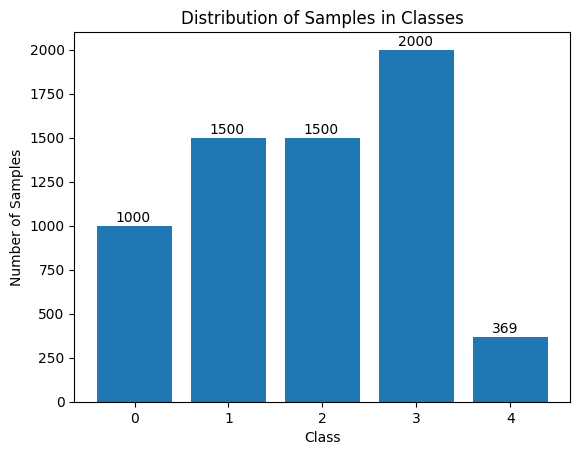

In [4]:
# Count the number of samples 
class_counts = {class_name: 0 for class_name in np.unique(train_generator.classes)}
for label in train_generator.classes:
    class_counts[label] += 1
    if sum(class_counts.values()) >= num_samples:
        break

# Plot the distribution
bars = plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples in Classes')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2, yval + 25, yval,)
plt.show()


# I Model

In [13]:

def Net(input_shape, num_classes, regl2 = 0.01, lr=0.001):

    model = Sequential()

    # C1 Convolutional Layer
    model.add(Conv2D(filters=6, input_shape=input_shape, kernel_size=(5,5),\
                     strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # C2 Convolutional Layer
    model.add(Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)

    # D1 Dense Layer
    model.add(Dense(120, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile
    adam = optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

# create the model
model = Net(input_shape,num_classes)
model.summary()

# define the callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=3)

# history of results (set to None when initializing a new mdoel)
history = None


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 92, 92, 6)         456       
                                                                 
 activation_4 (Activation)   (None, 92, 92, 6)         0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 46, 46, 6)         0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 46, 46, 6)         24        
 chNormalization)                                                
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 42, 16)        2416      
                                                                 
 activation_5 (Activation)   (None, 42, 42, 16)       

## Train

In [6]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_generator.classes), y = train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 1.2738, 1: 0.8492, 2: 0.8492, 3: 0.6369, 4: 3.4520325203252034}


In [14]:
steps_per_epoch=train_generator.n//train_generator.batch_size
#val_steps=test_generator.n//test_generator.batch_size+1

epochs = 100  # sets number of epochs


try:
    # Record the start time
    start_time = time.time()
    h = model.fit(train_generator, epochs=epochs, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    #class_weight=class_weight_dict,\
                    callbacks=[callback]
                    #validation_data=test_generator,\
                    #validation_steps=val_steps
                    )
    # Record the end time
    end_time = time.time()
except KeyboardInterrupt:
    pass

# append current history
if history is None:
    history = h.history
else:
    history['loss'].extend(h.history['loss'])
    history['accuracy'].extend(h.history['accuracy'])
    #history['val_loss'].extend(h.history['val_loss'])
    #history['val_accuracy'].extend(h.history['val_accuracy'])

print("number of epochs trained: %d" %len(history['loss']))

# Calculate and print the training time
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Epoch 1/100
398/398 [==============================] - 9s 17ms/step - loss: 1.9527 - accuracy: 0.5171
Epoch 2/100
398/398 [==============================] - 6s 16ms/step - loss: 1.7408 - accuracy: 0.5465
Epoch 3/100
398/398 [==============================] - 6s 16ms/step - loss: 1.5726 - accuracy: 0.5552
Epoch 4/100
398/398 [==============================] - 7s 17ms/step - loss: 1.8546 - accuracy: 0.5503
Epoch 5/100
398/398 [==============================] - 7s 17ms/step - loss: 1.6146 - accuracy: 0.5536
Epoch 6/100
398/398 [==============================] - 7s 18ms/step - loss: 1.4680 - accuracy: 0.5665
Epoch 7/100
398/398 [==============================] - 7s 17ms/step - loss: 1.4734 - accuracy: 0.5615
Epoch 8/100
398/398 [==============================] - 7s 18ms/step - loss: 1.4855 - accuracy: 0.5583
Epoch 9/100
398/398 [==============================] - 7s 18ms/step - loss: 1.4691 - accuracy: 0.5582
number of epochs trained: 9
Training time: 64.51114749908447 seconds


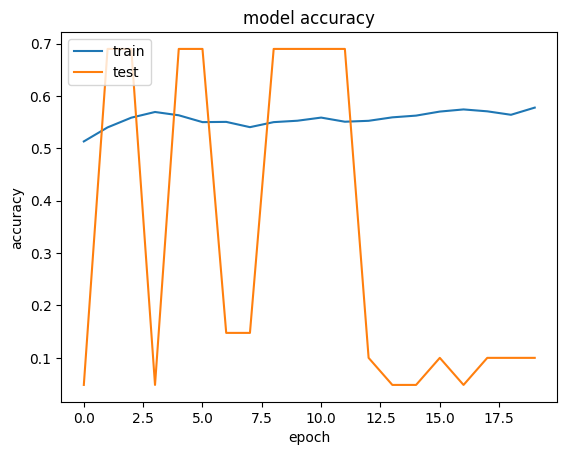

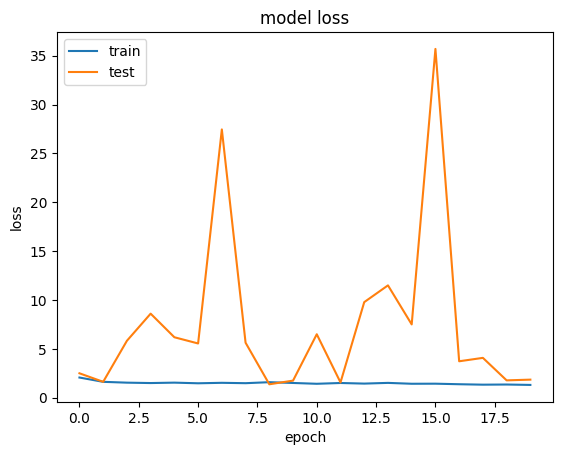

In [ ]:
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') #label of line
plt.show()

## Save model

In [10]:
models_dir = 'models'
modelname = 'model1_%d_epochs' %len(history['loss'])

def savemodel(problem,model,history):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)
    filename = os.path.join(models_dir, '%s_history.pkl' %problem)
    with open(filename, 'wb') as f:
        pickle.dump(history, f)
    print("History saved successfully on file %s\n" %filename)

# Save model and history
savemodel(modelname,model,model.history)


/home/gioia/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Model saved successfully on file models/model1_24_epochs.h5

History saved successfully on file models/model1_24_epochs_history.pkl



## Evaluate

In [ ]:
#model = tf.keras.models.load_model('models/model1_NoAug_20_epochs.h5')

2023-12-27 22:35:34.308900: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-27 22:35:34.309984: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-27 22:35:34.310025: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-27 22:35:34.314078: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-27 22:35:34.314183: I external/local_xla/xla/stream_executor

In [8]:
val_steps=test_generator.n//test_generator.batch_size+1
print(val_steps)
loss, acc = model.evaluate(test_generator,verbose=1,steps=val_steps)
pred = model.predict(test_generator,verbose=1,steps=val_steps).argmax(axis=1)
#print(pred)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)
print(classification_report(test_generator.classes, pred, target_names=classnames,digits=4))


172
172/172 [==============================] - 2s 8ms/step
Test loss: 1.241558
Test accuracy: 0.634413
              precision    recall  f1-score   support

           0     0.2045    0.4135    0.2736       133
           1     0.4064    0.5527    0.4684       275
           2     0.4411    0.7192    0.5468       406
           3     0.8675    0.6561    0.7471      1896
           4     0.1000    0.0256    0.0408        39

    accuracy                         0.6344      2749
   macro avg     0.4039    0.4734    0.4154      2749
weighted avg     0.7154    0.6344    0.6567      2749



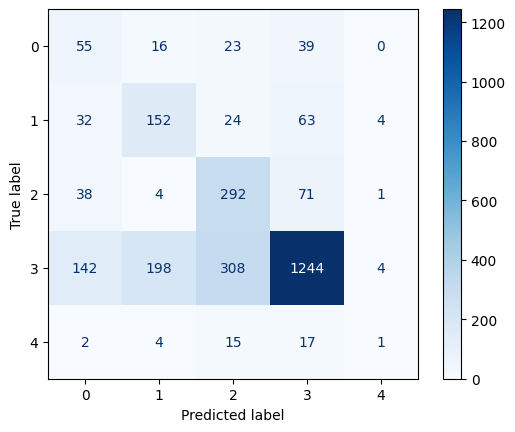

True                 Predicted         	errors 	err % 
------------------------------------------------------------------
3                ->  2                 	308 	11.20 % 
3                ->  1                 	198 	7.20 % 
3                ->  0                 	142 	5.17 % 
2                ->  3                 	71 	2.58 % 
1                ->  3                 	63 	2.29 % 
0                ->  3                 	39 	1.42 % 
2                ->  0                 	38 	1.38 % 
1                ->  0                 	32 	1.16 % 
1                ->  2                 	24 	0.87 % 
0                ->  2                 	23 	0.84 % 
4                ->  3                 	17 	0.62 % 
0                ->  1                 	16 	0.58 % 
4                ->  2                 	15 	0.55 % 
2                ->  1                 	4 	0.15 % 
1                ->  4                 	4 	0.15 % 
3                ->  4                 	4 	0.15 % 
4                ->  1                 	4 	0.

In [9]:
ytest = test_generator.classes
cm = confusion_matrix(ytest, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classnames)
disp.plot(cmap=plt.cm.Blues)
plt.show()


conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))

# Model with feature extraction

## Feature Extraction

## Classifier